**FORECASTING**
IMPORTING LIBRARIES

In [6]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

IMPORTING DATA

In [7]:
coke= pd.read_excel("CocaCola_Sales_Rawdata.xlsx")

In [8]:
coke.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [9]:
coke.tail()

,Quarter,Sales
37,Q2_95,4936.0
38,Q3_95,4895.0
39,Q4_95,4333.0
40,Q1_96,4194.0
41,Q2_96,5253.0


In [10]:
coke.shape

(42, 2)

In [11]:
coke.isnull().sum()

Quarter    0
Sales      0
dtype: int64

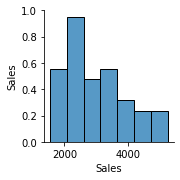

In [12]:
import seaborn as sns
sns.pairplot(coke)

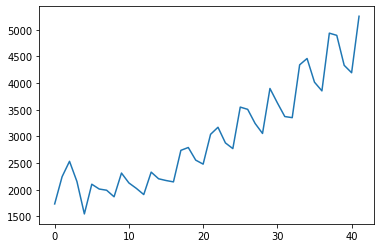

In [13]:
coke.Sales.plot()

In [14]:
coke['Quarters']= 0
coke['Year'] = 0
for i in range(42):
    p = coke["Quarter"][i]
    coke['Quarters'][i]= p[0:2]
    coke['Year'][i]= p[3:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
# Prepring dummies 
Quarters_Dummies = pd.DataFrame(pd.get_dummies(coke['Quarters']))
coke1 = pd.concat([coke,Quarters_Dummies],axis = 1)

In [16]:
coke1["t"]=np.arange(1,43)

In [17]:
coke1["t_squared"] = coke1["t"]*coke1["t"]
coke1.columns

Index(['Quarter', 'Sales', 'Quarters', 'Year', 'Q1', 'Q2', 'Q3', 'Q4', 't',
       't_squared'],
      dtype='object')

In [18]:
coke1["Log_Sales"]=np.log(coke1["Sales"])

# visualize the data

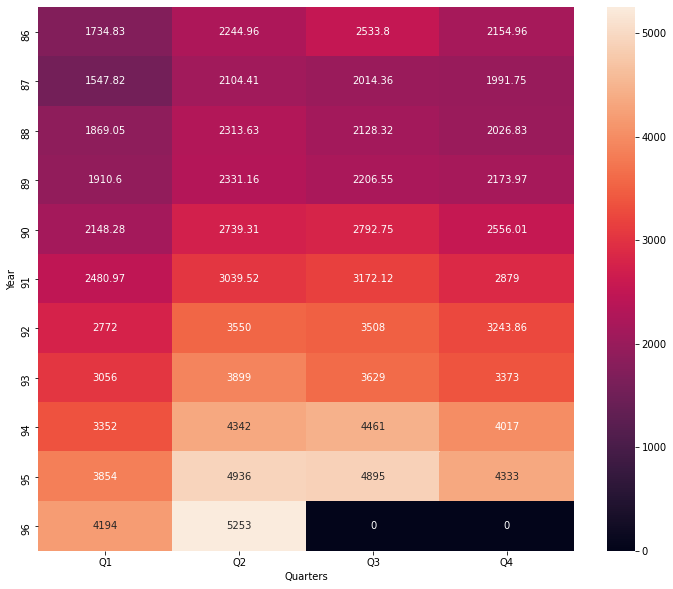

In [19]:
#

plt.figure(figsize=(12,10))
plot_month_y = pd.pivot_table(data = coke,values="Sales",index="Year",columns="Quarters"
                             ,aggfunc="mean",fill_value=0)
sns.heatmap(plot_month_y,annot=True,fmt = "g")

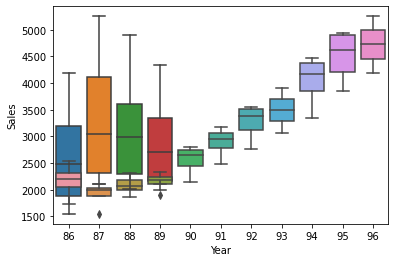

In [20]:
sns.boxplot(x="Quarters",y="Sales",data=coke1)
sns.boxplot(x="Year",y="Sales",data=coke1)

In [21]:
Train = coke1.head(38)
Test = coke1.tail(4)

In [22]:
# Linear model
import statsmodels.formula.api as smf
linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rmse_linear

591.553295722396

In [23]:
# Exponential
Exp = smf.ols('Log_Sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

466.2479731067161

In [24]:
# Quadratic
Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

475.5618351831482

In [25]:
# Additive seasonality
add_sea = smf.ols('Sales~Q1+Q2+Q3',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Q1','Q2','Q3']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1860.0238154547278

In [26]:
# Additive Seasonality Quadratic
add_sea_Quad = smf.ols('Sales~t+t_squared+Q1+Q2+Q3',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Q1','Q2','Q3','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

301.73800719351857

In [27]:
# Multiplicative Seasonality
Mul_sea = smf.ols('Log_Sales~Q1+Q2+Q3',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1963.3896400779727

In [28]:
# Multiplicative Additive Seasonality
Mul_Add_sea = smf.ols('Log_Sales~t+Q1+Q2+Q3',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

225.52439049816806

In [29]:
#tabulating the rmse values

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse

,MODEL,RMSE_Values
0,rmse_linear,591.553296
1,rmse_Exp,466.247973
2,rmse_Quad,475.561835
3,rmse_add_sea,1860.023815
4,rmse_add_sea_quad,301.738007
5,rmse_Mult_sea,1963.389640
6,rmse_Mult_add_sea,225.524390


#225.52439049818733  
# multiplicative additive seasonality is best model